In [63]:
import numpy as np


class Gate:
    def forward(self):
        raise NotImplementedError

    def backward(self):
        raise NotImplementedError


class AddGate(Gate):
    def forward(self, x, y):
        self.x = x
        self.y = y
        return x + y

    def backward(self, dz):
        dx = dz * np.ones_like(self.x)
        dy = dz * np.ones_like(self.y)
        return dx, dy
class MulGate(Gate):
    def forward(self, x, y):
        self.x = x
        self.y = y
        return x * y

    def backward(self, dz):
        dx = dz * self.y
        dy = dz * self.x
        return dx, dy   
class PowerGate(Gate):
    def forward(self, x, y):
        self.x = x
        self.y = y
        return np.power(x, y)

    def backward(self, dz, grad_output):
        dx = dz * self.y * np.power(self.x, self.y - 1) * grad_output
        dy = dz * np.log(self.x) * np.power(self.x, self.y) * grad_output
        return dx, dy
     

In [64]:
class ActivationFunction:
    @staticmethod
    def relu(z):
        return np.maximum(0, z)

    @staticmethod
    def sigmoid(z):
        return 1 / (1 + np.exp(-z))

    @staticmethod
    def softmax(z):
        exp_z = np.exp(z - np.max(z, axis=1, keepdims=True))
        return exp_z / np.sum(exp_z, axis=1, keepdims=True)

    

In [65]:

class BinaryCrossEntropyLoss(Gate):
    def forward(self, y_pred, y_true):
        # Implement binary cross-entropy forward pass
        return -np.mean(y_true * np.log(y_pred) + (1 - y_true) * np.log(1 - y_pred))

    def backward(self, y_pred, y_true):
        # Implement binary cross-entropy backward pass
        return (y_pred - y_true) / (y_pred * (1 - y_pred))

class L2Loss(Gate):
    def forward(self, y_pred, y_true):
        # Ensure y_pred and y_true have the same shape
        y_pred = y_pred.reshape(y_true.shape)

        # Implement L2 loss forward pass
        return 0.5 * np.mean((y_pred - y_true) ** 2)

    def backward(self, A_output, y_true):
        # Ensure A_output and y_true have the same shape
        A_output = A_output.reshape(y_true.shape)

        # Implement L2 loss backward pass
        return A_output - y_true


In [66]:
import matplotlib.pyplot as plt
class Model:
    def __init__(self, layers_dim, activation_func, loss):
        self.layers_dim = layers_dim
        self.activation_func = activation_func
        self.loss = loss
        self.params = self.initialize_parameters()

    def initialize_parameters(self):
        np.random.seed(42)
        params = {}
        for i in range(1, len(self.layers_dim)):
            params[f'W{i}'] = np.random.randn(self.layers_dim[i], self.layers_dim[i-1]) * 0.01
            params[f'b{i}'] = np.zeros((self.layers_dim[i], 1))
        return params

    def forward(self, X):
        A = X
        for i in range(1, len(self.layers_dim) - 1):
            Z = np.dot(self.params[f'W{i}'], A) + self.params[f'b{i}']
            A = self.activation_func.softmax(Z)

        Z_output = np.dot(self.params[f'W{len(self.layers_dim) - 1}'], A) + self.params[f'b{len(self.layers_dim) - 1}']
        A_output = self.activation_func.softmax(Z_output)

        return A_output
    def backward(self, X, Y, A_output):
     m = X.shape[1]
     grads = {}
     dA_output = self.loss.backward(A_output, Y)
     dZ_output = dA_output  # Assuming softmax and L2Loss
     for i in range(len(self.layers_dim) - 2, 0, -1):
        dA = np.dot(self.params[f'W{i+1}'].T, dZ_output)
        Z = np.dot(self.params[f'W{i}'], X) + self.params[f'b{i}']
        A = self.activation_func.softmax(Z)
        dZ = dA * A * (1 - A)
        grads[f'dW{i}'] = np.dot(dZ, X.T) / m
        grads[f'db{i}'] = np.sum(dZ, axis=1, keepdims=True) / m
        dZ_output = dZ
     return grads

    def update_parameters(self, grads, learning_rate):
     for i in range(1, len(self.layers_dim) - 1):  # Fix the loop range
        self.params[f'W{i}'] -= learning_rate * grads[f'dW{i}']
        self.params[f'b{i}'] -= learning_rate * grads[f'db{i}']


    import matplotlib.pyplot as plt



    def train(self, X, Y, player_names, learning_rate, num_epochs, gradient_descent_method='batch',
          batch_size=None, dropout_prob=None, l1_lambda=None, early_stopping=False,
          validation_data=None, patience=10):
     losses = []

     for epoch in range(num_epochs):
        if gradient_descent_method == 'batch':
            A_output = self.forward(X)
            loss = self.loss.forward(A_output, Y)
            grads = self.backward(X, Y, A_output)
            self.update_parameters(grads, learning_rate)

        elif gradient_descent_method == 'stochastic':
            for i in range(X.shape[1]):
                sample_X = X[:, i:i+1]
                sample_y = Y[:, i:i+1]
                A_output = self.forward(sample_X)
                loss = self.loss.forward(A_output, sample_y)
                grads = self.backward(sample_X, sample_y, A_output)
                self.update_parameters(grads, learning_rate)

        elif gradient_descent_method == 'mini_batch':
            if batch_size is None:
                raise ValueError("Batch size must be specified for mini-batch gradient descent.")
            for i in range(0, X.shape[1], batch_size):
                mini_batch_X = X[:, i:i+batch_size]
                mini_batch_y = Y[:, i:i+batch_size]
                A_output = self.forward(mini_batch_X)
                loss = self.loss.forward(A_output, mini_batch_y)
                grads = self.backward(mini_batch_X, mini_batch_y, A_output)
                self.update_parameters(grads, learning_rate)

        losses.append(loss)

        if epoch % 100 == 0:
            print(f"Epoch {epoch}, Loss: {loss}")

            
        

            
    # Plot the loss curve
     plt.plot(range(num_epochs), losses, label=gradient_descent_method)
     plt.xlabel('Epoch')
     plt.ylabel('Loss')
     plt.title(f'Loss Curve - {gradient_descent_method}')
     plt.legend()
     plt.show()

     
    def predict(self, X):
        return self.forward(X)


In [67]:
class L1Regularization:
    def __init__(self, alpha):
        self.alpha = alpha

    def apply(self, weights):
        return self.alpha * np.sum(np.abs(weights))


class Dropout:
    def __init__(self, dropout_rate):
        self.dropout_rate = dropout_rate
        self.mask = None

    def apply(self, activations, training=True):
        if training:
            self.mask = (np.random.rand(*activations.shape) < (1 - self.dropout_rate)) / (1 - self.dropout_rate)
            return activations * self.mask
        else:
            return activations


class EarlyStopping:
    def __init__(self, patience):
        self.patience = patience
        self.best_loss = float('inf')
        self.counter = 0

    def check_loss(self, loss):
        if loss < self.best_loss:
            self.best_loss = loss
            self.counter = 0
        else:
            self.counter += 1
            if self.counter >= self.patience:
                print("Training stopped early due to lack of improvement.")
                return True
        return False


In [68]:
class LearningRateScheduler:
    def __init__(self, initial_lr, schedule_type='exponential', decay_rate=0.9):
        self.lr = initial_lr
        self.schedule_type = schedule_type
        self.decay_rate = decay_rate

    def update_learning_rate(self, epoch):
        if self.schedule_type == 'exponential':
            self.lr *= self.decay_rate
        elif self.schedule_type == 'step':
            if epoch % 5 == 0:  
                self.lr *= self.decay_rate
        elif self.schedule_type == 'adaptive':
            
            pass
        

        return self.lr


In [69]:
from itertools import product

class HyperparameterTuner:
    def __init__(self, model_class, hyperparameters_grid, X_train, y_train, X_val, y_val, num_epochs=5):
        self.model_class = model_class
        self.hyperparameters_grid = hyperparameters_grid
        self.X_train, self.y_train = X_train, y_train
        self.X_val, self.y_val = X_val, y_val
        self.num_epochs = num_epochs

    def grid_search(self):
        best_model = None
        best_val_loss = float('inf')

        for hyperparameters in product(*self.hyperparameters_grid.values()):
            model = self.model_class(*hyperparameters)
            model.train(self.X_train, self.y_train, num_epochs=self.num_epochs, learning_rate=0.01)

            val_output = model.predict(self.X_val)
            val_loss = model.loss(self.y_val, val_output)

            if val_loss < best_val_loss:
                best_val_loss = val_loss
                best_model = model

        return best_model


In [70]:
class BatchNormalization(Gate):
    def __init__(self, input_size):
        self.gamma = np.ones((1, input_size))  # Scaling parameter
        self.beta = np.zeros((1, input_size))  # Shifting parameter
        self.epsilon = 1e-5  # Small constant to avoid division by zero
        self.mean = None
        self.variance = None

    def forward(self, x):
        self.mean = np.mean(x, axis=0, keepdims=True)
        self.variance = np.var(x, axis=0, keepdims=True)
        normalized_x = (x - self.mean) / np.sqrt(self.variance + self.epsilon)
        return self.gamma * normalized_x + self.beta

    def backward(self, dz):
        m = dz.shape[0]
        dx_normalized = dz * self.gamma
        dvariance = np.sum(dx_normalized * (self.variance + self.epsilon)**(-1.5) * (self.mean - self.x), axis=0, keepdims=True)
        dmean = np.sum(dx_normalized * (-1 / np.sqrt(self.variance + self.epsilon)), axis=0, keepdims=True) + \
                dvariance * np.sum(-2 * (self.mean - self.x), axis=0, keepdims=True) / m
        dx = dx_normalized / np.sqrt(self.variance + self.epsilon) + dvariance * 2 * (self.mean - self.x) / m + dmean / m
        dgamma = np.sum(dz * self.normalized_x, axis=0, keepdims=True)
        dbeta = np.sum(dz, axis=0, keepdims=True)
        return dx, dgamma, dbeta


Epoch 0, Loss: 0.031236670972338954
Epoch 100, Loss: 0.03123667097233633
Epoch 200, Loss: 0.03123667097233372
Epoch 300, Loss: 0.031236670972331095
Epoch 400, Loss: 0.031236670972328486
Epoch 500, Loss: 0.03123667097232587
Epoch 600, Loss: 0.031236670972323258
Epoch 700, Loss: 0.031236670972320635
Epoch 800, Loss: 0.031236670972318026
Epoch 900, Loss: 0.031236670972315406
Epoch 1000, Loss: 0.031236670972312797
Epoch 1100, Loss: 0.031236670972310174
Epoch 1200, Loss: 0.031236670972307562
Epoch 1300, Loss: 0.03123667097230494
Epoch 1400, Loss: 0.03123667097230233
Epoch 1500, Loss: 0.03123667097229971
Epoch 1600, Loss: 0.031236670972297095
Epoch 1700, Loss: 0.03123667097229448
Epoch 1800, Loss: 0.031236670972291866
Epoch 1900, Loss: 0.03123667097228925
Epoch 2000, Loss: 0.031236670972286634
Epoch 2100, Loss: 0.031236670972284022
Epoch 2200, Loss: 0.0312366709722814
Epoch 2300, Loss: 0.031236670972278783
Epoch 2400, Loss: 0.03123667097227617
Epoch 2500, Loss: 0.03123667097227356
Epoch 2600

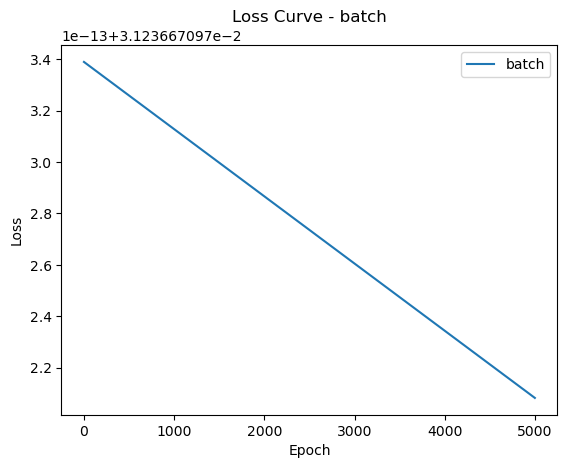

Epoch 0, Loss: 0.46875
Epoch 100, Loss: 0.46875
Epoch 200, Loss: 0.46875
Epoch 300, Loss: 0.46875
Epoch 400, Loss: 0.46875
Epoch 500, Loss: 0.46875
Epoch 600, Loss: 0.46875
Epoch 700, Loss: 0.46875
Epoch 800, Loss: 0.46875
Epoch 900, Loss: 0.46875
Epoch 1000, Loss: 0.46875
Epoch 1100, Loss: 0.46875
Epoch 1200, Loss: 0.46875
Epoch 1300, Loss: 0.46875
Epoch 1400, Loss: 0.46875
Epoch 1500, Loss: 0.46875
Epoch 1600, Loss: 0.46875
Epoch 1700, Loss: 0.46875
Epoch 1800, Loss: 0.46875
Epoch 1900, Loss: 0.46875
Epoch 2000, Loss: 0.46875
Epoch 2100, Loss: 0.46875
Epoch 2200, Loss: 0.46875
Epoch 2300, Loss: 0.46875
Epoch 2400, Loss: 0.46875
Epoch 2500, Loss: 0.46875
Epoch 2600, Loss: 0.46875
Epoch 2700, Loss: 0.46875
Epoch 2800, Loss: 0.46875
Epoch 2900, Loss: 0.46875
Epoch 3000, Loss: 0.46875
Epoch 3100, Loss: 0.46875
Epoch 3200, Loss: 0.46875
Epoch 3300, Loss: 0.46875
Epoch 3400, Loss: 0.46875
Epoch 3500, Loss: 0.46875
Epoch 3600, Loss: 0.46875
Epoch 3700, Loss: 0.46875
Epoch 3800, Loss: 0.4687

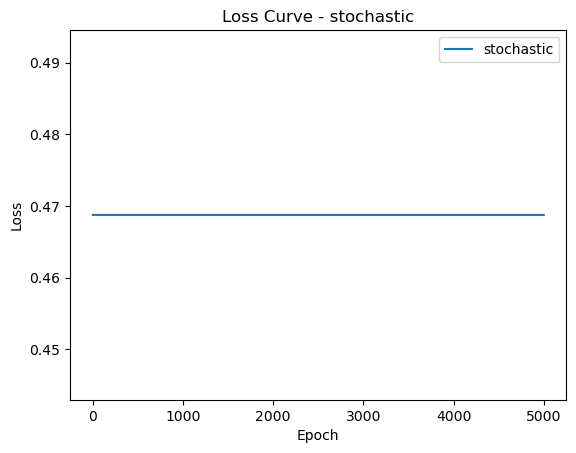

Epoch 0, Loss: 0.030478712211609162
Epoch 100, Loss: 0.030475459156761014
Epoch 200, Loss: 0.030472206746958004
Epoch 300, Loss: 0.030468954982678802
Epoch 400, Loss: 0.03046570386691991
Epoch 500, Loss: 0.030462453409810304
Epoch 600, Loss: 0.030459203632980103
Epoch 700, Loss: 0.03045595457369142
Epoch 800, Loss: 0.030452706288737055
Epoch 900, Loss: 0.030449458858110606
Epoch 1000, Loss: 0.030446212388447556
Epoch 1100, Loss: 0.030442967016233304
Epoch 1200, Loss: 0.03043972291076966
Epoch 1300, Loss: 0.03043648027688755
Epoch 1400, Loss: 0.030433239357389317
Epoch 1500, Loss: 0.030430000435200815
Epoch 1600, Loss: 0.030426763835210265
Epoch 1700, Loss: 0.030423529925768435
Epoch 1800, Loss: 0.03042029911982353
Epoch 1900, Loss: 0.030417071875663275
Epoch 2000, Loss: 0.03041384869723767
Epoch 2100, Loss: 0.030410630134037317
Epoch 2200, Loss: 0.030407416780505594
Epoch 2300, Loss: 0.03040420927496701
Epoch 2400, Loss: 0.030401008298059806
Epoch 2500, Loss: 0.030397814570667654
Epoch

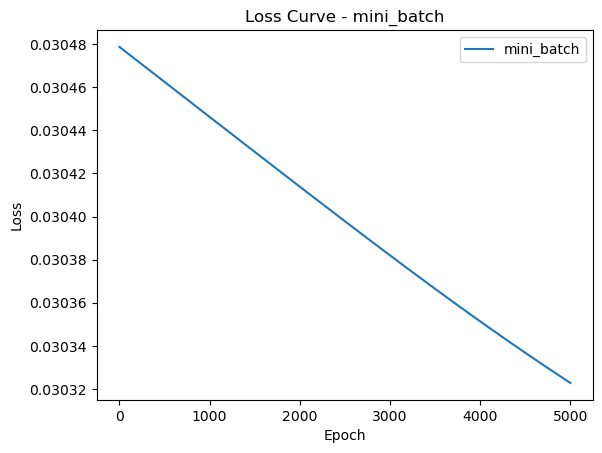

Predicted Labels: ['ST' 'ST' 'CB' ... 'CB' 'CB' 'CB']
Name: Mohamed Salah, Actual Position: CAM, Predicted Position: ST
Name: Ousmane Dembélé, Actual Position: RW, Predicted Position: ST
Name: Raphaël Varane, Actual Position: CB, Predicted Position: CB
Name: Cristiano Ronaldo, Actual Position: LW, Predicted Position: ST
Name: Lionel Messi, Actual Position: CF, Predicted Position: ST
Name: Robert Lewandowski, Actual Position: ST, Predicted Position: ST
Name: Pelé, Actual Position: CAM, Predicted Position: ST
Name: Neymar Jr, Actual Position: CAM, Predicted Position: ST
Name: Wissam Ben Yedder, Actual Position: ST, Predicted Position: ST
Name: Abedi Pelé, Actual Position: LW, Predicted Position: LM
Name: David Ginola, Actual Position: ST, Predicted Position: ST
Name: N'Golo Kanté, Actual Position: CAM, Predicted Position: CAM
Name: Franck Ribéry, Actual Position: LW, Predicted Position: ST
Name: Alexis Sánchez, Actual Position: CF, Predicted Position: ST
Name: Kalidou Koulibaly, Actual P

In [71]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
import matplotlib.pyplot as plt
import numpy as np

# Load your CSV data
data = pd.read_csv("C:\\Users\\king\\Downloads\\archive (3)\\Players\\Players\\Fifa22.csv", encoding='utf-8')

# Handle missing values (if any)
data = data.dropna()

# Encode categorical variables
label_encoder = LabelEncoder()
data['Position'] = label_encoder.fit_transform(data['Position'])

# Split the dataset into features (X) and target labels (Y)
X = data.drop(['Position', 'Nombre'], axis=1).values.T
Y = data['Position'].values
player_names = data['Nombre'].values

# Standardize the features (optional but often recommended for neural networks)
scaler = StandardScaler()
X = scaler.fit_transform(X)

# One-hot encode the target labels
num_classes = len(label_encoder.classes_)
Y_one_hot = np.eye(num_classes)[Y]

Y = Y.astype(int)  # Convert target labels to integers
# Example usage with softmax activation, L2 loss, and L1 regularization
layers_dim = [X.shape[0], 128, num_classes]  # Adjust num_classes based on your number of positions
activation_func = ActivationFunction()
loss = L2Loss()

model = Model(layers_dim, activation_func, loss)

# Train and print predicted positions for each method
model.train(X, Y_one_hot.T, player_names, num_epochs=5000, learning_rate=0.01,
            gradient_descent_method='batch', batch_size=None,
            dropout_prob=None, l1_lambda=0.01, early_stopping=False, validation_data=None, patience=10)

model.train(X, Y_one_hot.T, player_names, num_epochs=5000, learning_rate=0.01,
            gradient_descent_method='stochastic', batch_size=None,
            dropout_prob=None, l1_lambda=0.01, early_stopping=False, validation_data=None, patience=10)

# Initialize losses list outside the loop
losses = []

model.train(X, Y_one_hot.T, player_names, num_epochs=5000, learning_rate=0.01,
            gradient_descent_method='mini_batch', batch_size=64,
            dropout_prob=None, l1_lambda=0.01, early_stopping=False, validation_data=None, patience=10)

# Extracting actual labels from one-hot encoded matrix
actual_labels = np.argmax(Y_one_hot.T, axis=0)

# Use the label_encoder to transform the labels back to the original positions
actual_positions = label_encoder.inverse_transform(actual_labels)
predicted_labels = np.argmax(model.predict(X), axis=0)

# Use the label_encoder to transform the predicted labels back to the original positions
predicted_positions = label_encoder.inverse_transform(predicted_labels)

# Print the predicted positions
print(f"Predicted Labels: {predicted_positions}")

# Print player names along with actual and predicted positions
for i in range(len(player_names)):
    print(f"Name: {player_names[i]}, Actual Position: {actual_positions[i]}, Predicted Position: {predicted_positions[i]}")


In [72]:
def custom_accuracy(actual_positions, predicted_positions):
    correct = 0
    total = len(actual_positions)
    
    for actual, predicted in zip(actual_positions, predicted_positions):
        if actual == predicted or \
           (actual == 'CAM' and predicted in ['ST', 'CM', 'LW', 'RW']) or \
           (actual == 'LM' and predicted in ['RM', 'ST', 'RW', 'LW']) or \
           (actual == 'RM' and predicted in ['LM', 'ST', 'RW', 'LW']) or \
           (actual == 'LW' and predicted in ['LM', 'ST', 'RW', 'RM']) or \
           (actual == 'RW' and predicted in ['LM', 'ST', 'RM', 'LW']):
            correct += 1
    
    accuracy = correct / total
    return accuracy * 100

# Calculate and print custom accuracy
custom_acc = custom_accuracy(actual_positions, predicted_positions)
print(f"Custom Accuracy: {custom_acc:.2f}%")


Custom Accuracy: 66.78%
